<h1><center> Monte Carlo Approximation</center></h1>
# 1. Basic
So far, we discussed various deterministic algorithms for posterior inference. The trouble with these methods is that they can be rather complicated to derive and somewhat limited in their domain of applicability.

In this chapter, we discuss an alternative class of algorithms based on the idea of Monte Carlo approximation. The idea is very simple: generate some samples from the posterior, $\theta^s \sim p(\theta|D)$, and then use these to compute any quantity of interest, such as posterior predictive $p(x_{new}|D)$. All of these quantities $\mathbb{E}(f)=\int f(\theta)p(\theta)d\theta$ can be approximated by
$$
\hat{\mathit{f}} \approx \frac{1}{S}\sum_{s=1}^S f(\theta^s)
$$
for some suitable function $f$. As long as the samples $\theta^s \sim p(\theta)$ , then $\mathbb{E}\left[\hat{\mathit{f}}\right]=\mathbb{E}\left[f\right]$ and so the estimator $\hat{\mathit{f}}$ has the correct mean. The variance of the estimator is given by
$$
var\left[\hat{f}\right]=\frac{1}{L}\mathbb{E}\left[(f-\mathbb{E}\left[f\right])^2\right]
$$
The main issue is:how do we efficiently generate samples from a probability distribution, particularly in high dimensions. We will firstly introduce the non-iterative method for generating independent samples.

# 2. Sampling from standard distributions
## 2.1  Using the cdf
The simplest method for sampling from a univariate distribution is based on the **invese probability transform**.Let $F$ be a cdf of some distribution we want to sample from, and let $F^{-1}$ be its inverse. Then we have the following result: If $U \sim U(0,1)$ is a uniform random variable, then $F^{-1}(U) \sim F$.

We can take the Gaussian distribution as a example.
$$
p(x)=\frac{1}{\sqrt{2\pi}}exp\left(\frac{-x^2}{2}\right)
$$
The cdf of the standard Gaussian distribution is:
\begin{align}
\Phi(x)&=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^x exp\left(\frac{-t^2}{2}\right)dt  \\
       &=\frac{1}{2}\left[1+erf(\frac{x}{\sqrt{2}})\right]
\end{align}
where the error function is given by:
$$
erf(x)=\frac{2}{\sqrt{\pi}}\int_0^x exp\left(-t^2\right)dt
$$
We can get the inverse function of cdf as 
$$
\Phi^{-1}(p)=\sqrt{2}\,erfInv (2p-1)
$$

The time of sampling 200 samples using inverse cdf algorithm is 0.000104
The time of sampling 200 samples using np.random.randn is 0.000046


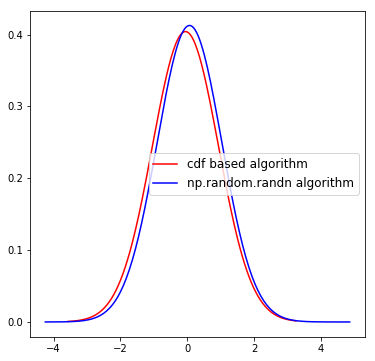

In [3]:
import numpy as np
import scipy
import seaborn
import matplotlib.pyplot as plt
import time

n_samples=200
np.random.seed(42)
start=time.time()
uniform_samples=np.random.rand(n_samples)
gaussian_samples=np.sqrt(2)*scipy.special.erfinv(2*uniform_samples-1)
end=time.time()
print("The time of sampling %d samples using inverse cdf algorithm is %.6f"%(n_samples,end-start))

start=time.time()
gaussian_samples_randn=np.random.randn(n_samples)
end=time.time()
print("The time of sampling %d samples using np.random.randn is %.6f"%(n_samples,end-start))
plt.figure(figsize=(6,6))
seaborn.distplot(gaussian_samples,
                 hist=False,
                 kde=False,
                 fit=scipy.stats.norm,
                 fit_kws={"color":'r'},
                 label="cdf based algorithm"
                )
seaborn.distplot(gaussian_samples_randn,
                hist=False,
                kde=False,
                fit=scipy.stats.norm,
                fit_kws={"color":'b'},
                label="np.random.randn algorithm")
plt.legend(fontsize=12)
plt.show()

## 2.2 Sampling from a Gaussian (Box-Muller method)
The inverse cdf algorithm is pretty slow for Gaussian distribution. We can use the Box-Muller method for faster sample. Suppose $U_1$ and $U_2$ are independent samples chosen from the uniform distribution on the unit interval $(0,1)$. Let $Z_0=\sqrt{-2lnU_1}cos(2\pi U_2)$ and $Z_1=\sqrt{-2lnU_1}sin(2\pi U_2)$.Then $Z_0$ and$Z_1$ are independent random variables with a standard normal distribution.

The time of sampling 200 samples using Box-Muller algorithm is 0.000191
The time of sampling 200 samples using np.random.randn is 0.000125


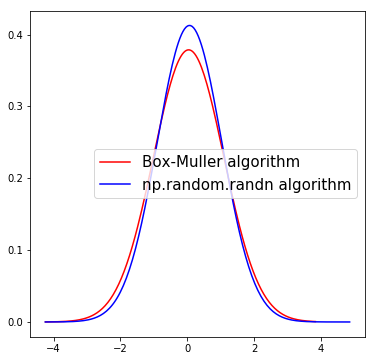

In [4]:
import numpy as np
import time

n_samples=200
np.random.seed(42)
start=time.time()
U=np.random.rand(int(n_samples/2),2)
R=np.sqrt(-2*np.log(U[:,0]))
Box_Muller_sample=np.hstack((R*np.cos(2*np.pi*U[:,1]),R*np.sin(2*np.pi*U[:,1])))
end=time.time()
print("The time of sampling %d samples using Box-Muller algorithm is %.6f"%(n_samples,end-start))

start=time.time()
gaussian_samples_randn=np.random.randn(n_samples)
end=time.time()
print("The time of sampling %d samples using np.random.randn is %.6f"%(n_samples,end-start))
plt.figure(figsize=(6,6))
seaborn.distplot(Box_Muller_sample,
                 hist=False,
                 kde=False,
                 fit=scipy.stats.norm,
                 fit_kws={"color":'r'},
                 label="Box-Muller algorithm"
                )
seaborn.distplot(gaussian_samples_randn,
                hist=False,
                kde=False,
                fit=scipy.stats.norm,
                fit_kws={"color":'b'},
                label="np.random.randn algorithm")
plt.legend(fontsize=15)
plt.show()

## 2.3 Rejection sampling
In rejection sampling, we create a **proposal distribution** $q(x)$ which satisfies $Mq(x) \geq \tilde{p}(x)$ for some constant $M$, where $\tilde{p}(x)$ is an unnormalized version of $p(x)$. We then sample $x \sim q(x)$, which corresponds to picking a random x location, and then we sample $u \sim U(0,1)$, which corresponds to picking a random height ($y$ location). 
If 
$$
u >\frac{\tilde{p}(x)}{Mq(x)}
$$
we reject the sample,otherwise we accept it. The probability of acceptance is
$$
p(accept)=\int \frac{\tilde{p}(x)}{Mq(x)}q(x)dx=\frac{1}{M}\int\tilde{p}(x)dx
$$
So we need to select M as tight as possble.

Suppose we want to draw samples from the posterior
$$
p(\theta|D)=\frac{p(D|\theta)p(\theta)}{p(D)}
$$
We can use rejection sampling with $\tilde{p}(\theta)=p(D|\theta)p(\theta)$ as the target distribution, $q(\theta)=p(\theta)$ as our proposal and $M=\underset{\theta}{max}\,p(D|\theta)$ is the MLE. We then accept points with probability
$$
\frac{\tilde{p}(\theta)}{Mq(\theta)}=\frac{p(D|\theta)}{p(D|\hat{\theta})}
$$

suppose we want to sample from a Beta distribution:


<IPython.core.display.Math object>

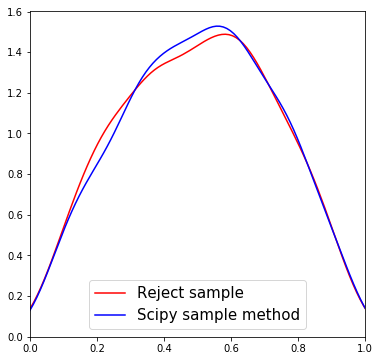

In [10]:
from IPython.display import display, Math, Latex
import numpy as np
import scipy
import seaborn
import matplotlib.pyplot as plt
print("suppose we want to sample from a Beta distribution:")
display(Math(r'Beta(x|\alpha,\beta)=\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}'
             r'x^{\alpha-1}(1-x)^{\beta-1}'))

alpha=2
beta=2
M=max_pdf=1.5 # The maximum value of the pdf of Beta(x|2,2) is 1.5, so we can use M=1.5 and q(x)=U(0,1)
np.random.seed(42)

n_samples=1000
samples_before_reject=np.random.rand(int(n_samples*M))
prob=np.random.rand(int(n_samples*M))
rv=scipy.stats.beta(a=2,b=2)
retained_samples=[prob<rv.pdf(samples_before_reject)/M]   #This is the reject step

final_samples=samples_before_reject[retained_samples]
plt.figure(figsize=(6,6))
seaborn.distplot(final_samples,
                hist=False,
                color='r',
                label="Reject sample")
seaborn.distplot(scipy.stats.beta(a=2,b=2).rvs(n_samples),
                hist=False,
                color='b',
                label='Scipy sample method')
plt.xlim([0,1])
plt.legend(fontsize=15)
plt.show()

## 2.4  Adaptive rejection sampling
We now discuss a method that can automatically come up with a tight upper envelope $q(x)$ to any log concave density $p(x)$. The idea is to upper bound the log density with a piecewise linear function.We choose the initial locations for the pieces based on a fixed grid over the support of the distribution. We then evaluate the gradient of the log density at these locations, and make the lines be tangent at these points.

Since the log of the envelope is piecewise linear, the envelope itself is piecewise exponenetial
$$
q(x)=M_i\lambda_iexp\left(-\lambda_i(x-x_{i-1})\right),\quad x \in[x_{i-1},x_i]
$$
where x i are the grid points.
![1.png](imgs/1.png)

## 2.5 Rejection sampling in high dimensions
It's clear that we want to make our proposal $q(x)$ as close as possible to the target distribution $p(x)$, while still being an upper bound. But this is quite hard to achieve, especially in high dimensions. To see this, consider sampling from $p(x) = \mathcal{N} (0, \sigma_p^2\mathbf{I})$ using as a proposal $q(x) = \mathcal{N} (0, \sigma_q^2\mathbf{I})$. Obviously we must have $\sigma_q^2 \geq \sigma_p^2$ in order to be an upper bound.In $D$ dimensions, the optimal value is given by $M=\left(\frac{\sigma_q}{\sigma_p}\right)^2$. The acceptance rate is $\frac{1}{M}$, which decreases exponentially fast with dimension.

# 3. Importance sampling
When we approximate integrals of the form
$$
\mathit{I}=\mathbb{E}\left[f\right]=\int f(x)p(x)dx
$$
using
$$
\hat{\mathit{I}}=\frac{1}{S}\sum_{s=1}^S f(x_s)
$$
The finite sum approximation to the expectation depends on being able to draw samples from the distribution $p(x)$. Suppose, however, that it is impractical to sample directly from $p(z)$. Furthermore, in many applications  f(x) is nearly zero outside a region $A$ for which $P(x \in A)$ is small. The set $A$ may have small volume, or it may be in the tail of the distribution. A plain sampling algorithm might lead to high variance because we don't put more attention on $A$.
## 3.1 Basic idea
It is clear intuitively that we must get some samples from the interesting or important region. We do this by sampling from a distribution that overweights the important region, hence the name **importance sampling**. Having oversampled the important region, we have to adjust our estimate somehow to account for having sampled from this other distribution

Importance sampling samples from any proposal $q(x)$. It then uses these samples to estimate the integral as follows
\begin{align}
\mathbb{E}\left[f\right]  &=\int f(x)\frac{p(x)}{q(x)}q(x)dx  \\
                          &=\frac{1}{S}\sum_{s=1}^S \frac{p(x^s)}{q(x^s)} f(x^s) \\
                          &=\frac{1}{S}\sum_{s=1}^S w_s\, f(x^s) \\
\end{align}
where 
$$
w_s=\frac{p(x^s)}{q(x^s)}
$$
are called **importance weights**.Note that, unlike rejection sampling, all of the samples generated are retained but with different weight

In [15]:
# Below we will use importance sampling method to calculate the variance of a laplace distribution
import scipy
import numpy as np

n_samples=200
np.random.seed(123)
samples=scipy.stats.norm.rvs(size=n_samples)
samples_variance=np.square(samples)
weights=scipy.stats.laplace.pdf(samples)/scipy.stats.norm.pdf(samples)
print("The importance sampling method result of the variance of a laplace distribution:%4f"
      %(np.mean(samples_variance*weights)))
print("The actual variance of a laplace distribution:%4f"%(scipy.stats.laplace.stats(moments='v')))

The importance sampling method result of the variance of a laplace distribution:1.787035
The actual variance of a laplace distribution:2.000000


## 3.2 Handing unnormalized distribution
It is frequently the case that we can evaluate the unnormalized target distribution $\tilde{p}(x)$, but not its normalization constant $Z_p$. We may also want to use an unnormalized proposal $\tilde{q}(x)$ with possible unknown normalization constant $Z_q$. We can do this as follows.First we evaluate
$$
\mathbb{E}\left[f\right]=\frac{Z_q}{Z_p}\int f(x)\frac{\tilde{p}(x)}{\tilde{q}(x)}q(x)dx \approx \frac{Z_q}{Z_p}\frac{1}{S}\sum_{s=1}^S\tilde{w}_sf(x^s)
$$
where 
$$
\tilde{w}^s=\frac{\tilde{p}(x^s)}{\tilde{q}(x^s)}
$$
is the unnormalized importance weight. We could use the same set of samples to evaluate the ratio $\frac{Z_p}{Z_q}$ as follows.
\begin{align}
\frac{Z_p}{Z_q}  &=\int \frac{\tilde{p}(x)}{Z_q}dx  \\
                 &=\int \frac{\tilde{p}(x)}{\tilde{q}(x)}q(x)dx \\
                 & \approx \frac{1}{S}\sum_{s=1}^S \tilde{w}^s
\end{align}
Hence
\begin{align}
\mathbb{E}\left[f\right] &\approx \frac{Z_q}{Z_p}\frac{1}{S}\sum_{s=1}^S\tilde{w}_sf(x^s)\\
                         &\approx \frac{\sum_{s=1}^S\tilde{w}_sf(x^s)}{\sum_{s=1}^S \tilde{w}^s} \\
                         &=\sum_{s=1}^S \bar{w}^s f(x^s)
\end{align}
where
$$
\bar{w}^s=\frac{\tilde{w}_s}{\sum_{s=1}^S \tilde{w}^s}
$$